### we simply need to compare output of edge, and agglo clustering
### and where agglo clustering is 1 we leave to 1 and do not take the 
### predictions from edge model

In [2]:
import numpy as np
from numpy import genfromtxt
from itertools import combinations
import torch
import math 
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%run r3b_clustering_def.ipynb
%run agglomerative_def.ipynb
%run ff_models_def.ipynb

In [2]:
def get_agglo_edge_ene(data,agglo_vals,edge_vals,true_vals):
    ene_list = []
    ene_true_list = []
    idx = 0
    well_reco = 0
    array_unique_events = np.unique(data[:,0])
    merge_tries = 0
    correctly_merged = 0
    for i in range(0,int(np.max(data,axis=0)[0])-(int(np.max(data,axis=0)[0])%3) ,3):
        mask = ((data[:,0] == i) | (data[:,0] == i+1) | (data[:,0] == i+2))
        evt = data[mask]
        pair_indices = list(combinations(range(evt.shape[0]), 2))
        ##pair indices which belong together...
        pred_comb = []
        ##TJ this is the new part with true stuff
        true_comb = []
        for m in range(evt.shape[0]):
            pred_comb.append((m,m))
            true_comb.append((m,m))
        for j in range (len(pair_indices)):
            if agglo_vals[idx+j] > 0.75:
                pred_comb.append(pair_indices[j])
            if ((agglo_vals[idx+j] < 0.75) and (edge_vals[idx+j] > 0.75)):
                merge_tries +=1
                pred_comb.append(pair_indices[j])
                if true_vals[idx+j] > 0.75: 
                    correctly_merged +=1
            if true_vals[idx+j] > 0.75:   
                true_comb.append(pair_indices[j])
        G = nx.Graph()
        G.add_edges_from(pred_comb)
        connected_components = list(nx.connected_components(G))
        ##TJ again, this it the addition for the true values
        T = nx.Graph()
        T.add_edges_from(true_comb)
        true_components = list(nx.connected_components(T))
        set_true = {frozenset(sublist) for sublist in true_components}
        set_pred = {frozenset(sublist) for sublist in connected_components}

        # Find the intersection of the two sets
        common_sublists = set_true.intersection(set_pred)

        well_reco += len(common_sublists)
        for k in range(len(connected_components)):
            columns_to_sum = evt[list(connected_components[k]),1]
            ene = np.sum(columns_to_sum)
            ene_list.append(ene)
        #make list true energy
        for l in range(len(true_components)):
            true_columns_to_sum = evt[list(true_components[l]),1]
            ene_true = np.sum(true_columns_to_sum)
            ene_true_list.append(ene_true)
        idx += len(pair_indices)
    single_hit_energies = []
    for i in range(data.shape[0]):
        single_hit_energies.append(data[i,1])
        
    #plt.hist(single_hit_energies,bins=70,range=(0,7),label="single hit energy",color="green",alpha=0.5)    
    plt.hist(ene_list,bins=100,range=(0,10),label="reconstructed energy",color="red",alpha=0.3)
    plt.grid()
    plt.hist(ene_true_list,bins=100,range=(0,10),label="true energies",color="blue",alpha=0.3)
    plt.legend()
    plt.yscale('log')
    well_reco = float(well_reco)/float(np.max(data,axis=0)[0])
    print("percentage of correctly merged hits/clusters:")
    print(correctly_merged/merge_tries)

    print("well reco...", well_reco)
    return (ene_list,ene_true_list,well_reco)

### 1)first run feed forward model on false negative to train the model

/tmp/ipykernel_5807/2638893087.py:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  input_data = torch.FloatTensor(ll)


Model's state_dict:
linear.weight 	 torch.Size([1000, 12])
linear.bias 	 torch.Size([1000])
another_linear.weight 	 torch.Size([100, 1000])
another_linear.bias 	 torch.Size([100])
another_linear_two.weight 	 torch.Size([100, 100])
another_linear_two.bias 	 torch.Size([100])
linear_back.weight 	 torch.Size([1, 100])
linear_back.bias 	 torch.Size([1])
epochnr: 0 0.0 %
epochnr: 1 0.01 %
epochnr: 2 0.02 %
epochnr: 3 0.03 %
epochnr: 4 0.04 %
epochnr: 5 0.05 %
epochnr: 6 0.06 %
epochnr: 7 0.06999999999999999 %
epochnr: 8 0.08 %
epochnr: 9 0.09 %
epochnr: 10 0.1 %
epochnr: 11 0.11 %
epochnr: 12 0.12 %
epochnr: 13 0.13 %
epochnr: 14 0.13999999999999999 %
epochnr: 15 0.15 %
epochnr: 16 0.16 %
epochnr: 17 0.16999999999999998 %
epochnr: 18 0.18 %
epochnr: 19 0.19 %
epochnr: 20 0.2 %
epochnr: 21 0.21 %
epochnr: 22 0.22 %
epochnr: 23 0.22999999999999998 %
epochnr: 24 0.24 %
epochnr: 25 0.25 %
epochnr: 26 0.26 %
epochnr: 27 0.27 %
epochnr: 28 0.27999999999999997 %
epochnr: 29 0.29 %
epochnr: 30 0.3 

/home/tobias/.local/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


well reco... 0.947398050737131


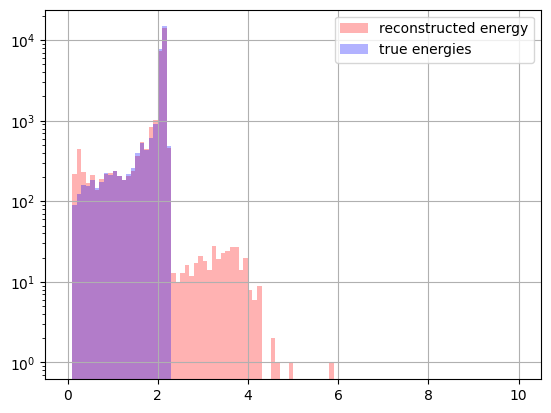

In [3]:
training_data = genfromtxt('training_all_output_false_negative.txt', delimiter=',')
training_data[:,4] =(training_data[:,4]-np.min(training_data[:,4]))/(np.max(training_data[:,4])-np.min(training_data[:,4]))
unique_values, continuous_numbers = np.unique(training_data[:,0], return_inverse=True)
training_data[:,0] = continuous_numbers
training_data[:,2] = training_data[:,2]*math.pi/180.
training_data[:,3] = training_data[:,3]*math.pi/180.
training_true = get_true_combinatorics(training_data)

input_training_data = manip_data_ff(training_data,12) ##second param gives number of features

pred_training = train_two_hidden_model(input_training_data,torch.FloatTensor(training_true),12,1000,5e-3,100)

training_reco = get_true_reco_ene(training_data,pred_training[0].tolist(),training_true)

In [3]:
plt.hist(pred_training[training_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
plt.hist(pred_training[training_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
plt.legend()

NameError: name 'pred_training' is not defined

### 2) then run the agglo model on the raw dataset test

13497
unique stuff:	 2.0
unique stuff:	 5.0
unique stuff:	 8.0
unique stuff:	 11.0
unique stuff:	 14.0
unique stuff:	 17.0
unique stuff:	 20.0
unique stuff:	 23.0
unique stuff:	 26.0
unique stuff:	 29.0
unique stuff:	 32.0
unique stuff:	 35.0
unique stuff:	 38.0
unique stuff:	 41.0
unique stuff:	 44.0
unique stuff:	 47.0
unique stuff:	 50.0
unique stuff:	 53.0
unique stuff:	 56.0
unique stuff:	 59.0
unique stuff:	 62.0
unique stuff:	 65.0
unique stuff:	 68.0
unique stuff:	 71.0
unique stuff:	 74.0
unique stuff:	 77.0
unique stuff:	 80.0
unique stuff:	 83.0
unique stuff:	 86.0
unique stuff:	 89.0
unique stuff:	 92.0
unique stuff:	 95.0
unique stuff:	 98.0
unique stuff:	 101.0
unique stuff:	 104.0
unique stuff:	 107.0
unique stuff:	 110.0
unique stuff:	 113.0
unique stuff:	 116.0
unique stuff:	 119.0
unique stuff:	 122.0
unique stuff:	 125.0
unique stuff:	 128.0
unique stuff:	 131.0
unique stuff:	 134.0
unique stuff:	 137.0
unique stuff:	 140.0
unique stuff:	 143.0
unique stuff:	 146.0
u

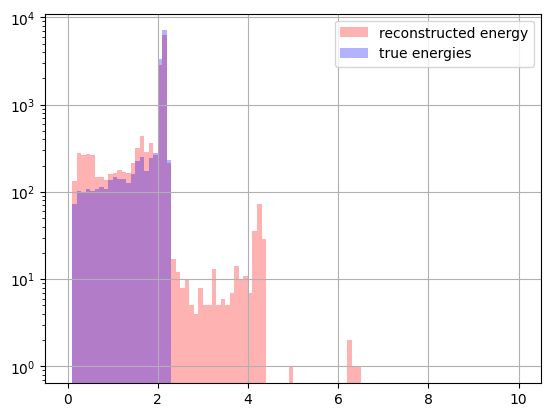

In [4]:
data = genfromtxt('validation_raw.txt', delimiter=',')
data[:,4] = data[:,4]+4500  #this step is needed, I only want positive time values, so that I can use the time as a radius

# ### structure of mydata : eventnr, energy, theta, phi, hit-time
data = data*[1.,1.,3.14159/180,3.14159/180,1.]
unique_values, continuous_numbers = np.unique(data[:,0], return_inverse=True)
data[:,0] = continuous_numbers
out_cluster_agglo = run_agglo_clustering(data,3540)

agglo_true = get_true_combinatorics(data)
agglo_reco = get_true_reco_ene(data,out_cluster_agglo,agglo_true)


### 3) then run the pretrained ff model on the raw dataset test

well reco... 0.3150603748425809


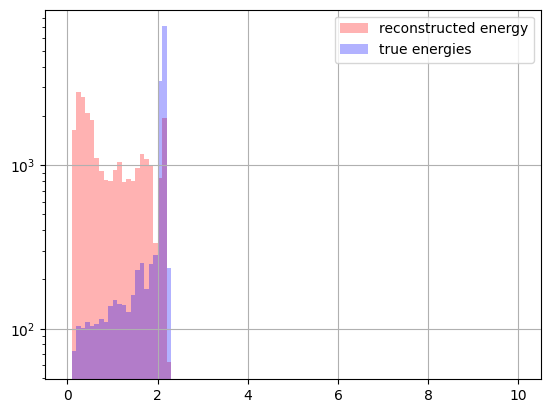

In [5]:
val_data = genfromtxt('validation_raw.txt', delimiter=',')
## some data manipulation needed
val_data[:,4] =(val_data[:,4]-np.min(val_data[:,4]))/(np.max(val_data[:,4])-np.min(val_data[:,4]))
unique_values, continuous_numbers = np.unique(val_data[:,0], return_inverse=True)
val_data[:,0] = continuous_numbers
val_data[:,2] = val_data[:,2]*math.pi/180.
val_data[:,3] = val_data[:,3]*math.pi/180.
val_true = get_true_combinatorics(val_data)
input_val_data = manip_data_ff(val_data,12) ##second param gives number of features

pred_val = validate_two_hidden_model(input_val_data,torch.FloatTensor(val_true),12,1000,5e-3,100)

val_reco = get_true_reco_ene(val_data,pred_val[0].tolist(),val_true)

### 4) combine the outputs of the agglo model and of the ff model and insert them into the "get_agglo_edge_ene"

percentage of correctly merged hits/clusters:
1.0
well reco... 0.8912512037928736


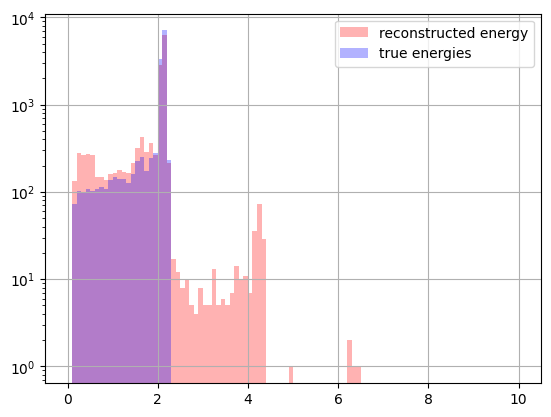

In [6]:
agglo_edge_val = get_agglo_edge_ene(val_data,out_cluster_agglo,pred_val[0].tolist(),val_true)